### NEWW 


## TRAINING AND ANALYSIS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),  # [B, 16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),
            # Additional layer to reduce the spatial dimensions to 1x1
            # nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=0),  # [B, 64, 1, 1]
            # nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

# Custom simplified decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # [B, 16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),                        # [B, 3, 32, 32]
            nn.Sigmoid()  # Normalize the output
        )

    def forward(self, x):
        return self.decoder(x.view(x.size(0), 64, 1, 1))



# Combined autoencoder with classifier
class AutoencoderWithClassifier(nn.Module):
    def __init__(self):
        super(AutoencoderWithClassifier, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        # Classifier for classification task
        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 10),
            nn.LogSoftmax(dim=1)            
        )

    def forward(self, x):
        encoded = self.encoder(x)  # [B, 256, 1, 1]
        embedding = encoded.view(encoded.size(0), -1)  # Flatten before passing to classifier
        decoded = self.decoder(encoded)
        class_logits = self.classifier(embedding)

        return decoded, class_logits

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1),  # [B, 16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 4 * 4, 32),  # Flatten the output to pass to classifier
            
            # Additional layer to reduce the spatial dimensions to 1x1
            # nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=0),  # [B, 64, 1, 1]
            # nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)

# Custom simplified decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 64 * 4 * 4),  # [B, 256]
            nn.ReLU(),
            nn.Unflatten(1, (64, 4, 4)),  # [B, 64, 4, 4]
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),   # [B, 16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=4, stride=2, padding=1),    # [B, 32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1),                        # [B, 3, 32, 32]
            nn.Sigmoid()  # Normalize the output
        )

    def forward(self, x):
        return self.decoder(x)  # [B, 256, 4, 4] matches encoder output



# Combined autoencoder with classifier
class AutoencoderWithClassifier(nn.Module):
    def __init__(self):
        super(AutoencoderWithClassifier, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        # Classifier for classification task
        self.classifier = nn.Sequential(
            nn.Linear(32, 10),  # Flattened input from encoder
            nn.LogSoftmax(dim=1)            
        )

    def forward(self, x):
        encoded = self.encoder(x)  # [B, 256, 1, 1]
        embedding = encoded.view(encoded.size(0), -1)  # Flatten before passing to classifier
        decoded = self.decoder(encoded)
        class_logits = self.classifier(embedding)

        return decoded, class_logits

In [3]:
# Loss functions
reconstruction_criterion = nn.MSELoss()
classification_criterion = nn.CrossEntropyLoss()

recon_loss_weight = 0.3
class_loss_weight = 0.6
sparse_loss_weight = 1

# Training function
def train_model_with_classification(model, dataloader, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_recon_loss = 0.0
        running_class_loss = 0.0
        running_sparse_loss = 0.0
        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            recon_images, class_logits = model(images)
            # print(recon_images.shape)
            # print(images.shape)
            
            # Calculate losses
            recon_loss = reconstruction_criterion(recon_images, images)  # Reconstruction loss
            class_loss = classification_criterion(class_logits, labels)  # Classification loss
            sparse_loss = torch.mean(torch.abs(model.encoder.encoder[-1].weight))
            total_loss = recon_loss_weight*recon_loss + class_loss_weight*class_loss + sparse_loss_weight*sparse_loss
            
            # Backward pass and optimize
            total_loss.backward()
            optimizer.step()
            
            # Track losses for display
            running_recon_loss += recon_loss.item()
            running_class_loss += class_loss.item()
            running_sparse_loss += sparse_loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Recon Loss: {running_recon_loss/len(dataloader):.4f}, Class Loss: {running_class_loss/len(dataloader):.4f}, Sparse Loss: {running_sparse_loss/len(dataloader):.4f}')

In [4]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoencoderWithClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Train the model
train_model_with_classification(model, train_loader, optimizer, num_epochs=20, device=device)


Files already downloaded and verified
Epoch [1/20], Recon Loss: 0.0426, Class Loss: 1.5891, Sparse Loss: 0.0229
Epoch [2/20], Recon Loss: 0.0330, Class Loss: 1.2909, Sparse Loss: 0.0322
Epoch [3/20], Recon Loss: 0.0302, Class Loss: 1.1755, Sparse Loss: 0.0369
Epoch [4/20], Recon Loss: 0.0296, Class Loss: 1.1035, Sparse Loss: 0.0387
Epoch [5/20], Recon Loss: 0.0290, Class Loss: 1.0403, Sparse Loss: 0.0394
Epoch [6/20], Recon Loss: 0.0292, Class Loss: 0.9942, Sparse Loss: 0.0389
Epoch [7/20], Recon Loss: 0.0299, Class Loss: 0.9580, Sparse Loss: 0.0381
Epoch [8/20], Recon Loss: 0.0306, Class Loss: 0.9287, Sparse Loss: 0.0375
Epoch [9/20], Recon Loss: 0.0311, Class Loss: 0.8941, Sparse Loss: 0.0370
Epoch [10/20], Recon Loss: 0.0317, Class Loss: 0.8710, Sparse Loss: 0.0370
Epoch [11/20], Recon Loss: 0.0317, Class Loss: 0.8420, Sparse Loss: 0.0363
Epoch [12/20], Recon Loss: 0.0323, Class Loss: 0.8291, Sparse Loss: 0.0368
Epoch [13/20], Recon Loss: 0.0324, Class Loss: 0.8103, Sparse Loss: 0.0

In [5]:
# Save model weights
torch.save(model.state_dict(), 'autoencoder_with_classifier_with_lin_encoder.pth')

In [6]:
# check the model accuracy
def check_accuracy(model, dataloader, device
):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            _, class_logits = model(images)
            _, predicted = torch.max(class_logits.data
            , 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Accuracy on training set
print(f'Accuracy on training set: {check_accuracy(model, train_loader, device) * 100:.2f}%')

# Accuracy on test set
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Accuracy on test set: {check_accuracy(model, test_loader, device) * 100:.2f}%')



Accuracy on training set: 78.49%
Accuracy on test set: 63.36%


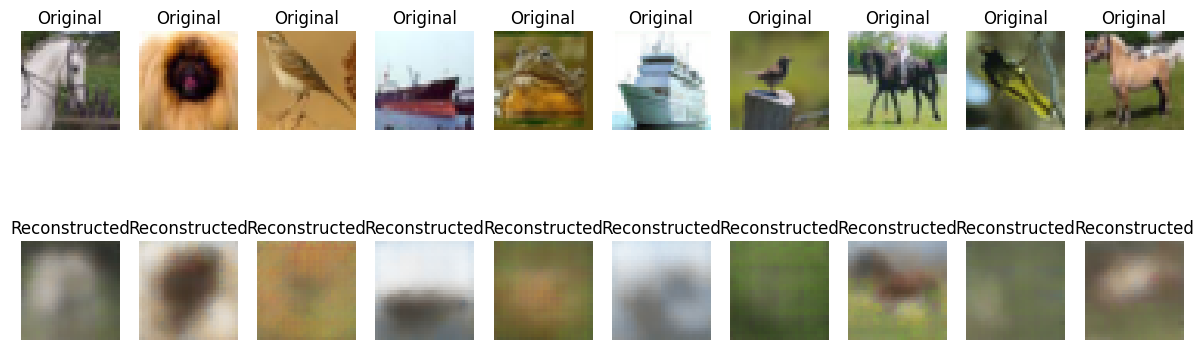

In [7]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, dataloader, device, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for evaluation
        images, _ = next(iter(dataloader))  # Get a batch of images
        images = images.to(device)
        recon_images, _ = model(images)  # Pass through the autoencoder to get reconstructions

        # Move tensors to CPU for plotting
        images = images.cpu()
        recon_images = recon_images.cpu()

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(images[i].permute(1, 2, 0))  # Change channel order for plotting
            axes[0, i].set_title("Original")
            axes[0, i].axis('off')

            # Reconstructed images
            axes[1, i].imshow(recon_images[i].permute(1, 2, 0))  # Change channel order for plotting
            axes[1, i].set_title("Reconstructed")
            axes[1, i].axis('off')

        plt.show()

# Visualize the reconstructions
visualize_reconstructions(model, train_loader, device)


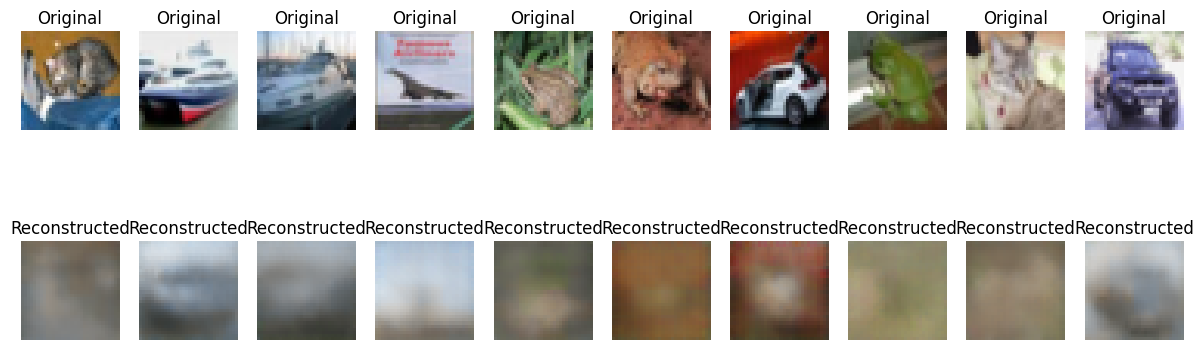

In [8]:
visualize_reconstructions(model, test_loader, device)

In [9]:
cifar_encoder = model.encoder

# Get the test images and their encodings
encodings = []
for images, _ in train_loader:
    encodings.append(cifar_encoder(images.to(device)).detach().cpu())
encodings = torch.cat(encodings)

# Get the top 10 images that activate each feature the most
top_images = []
for i in range(10):
    top_images.append(encodings[:, i].topk(10).indices)
top_images = torch.stack(top_images)

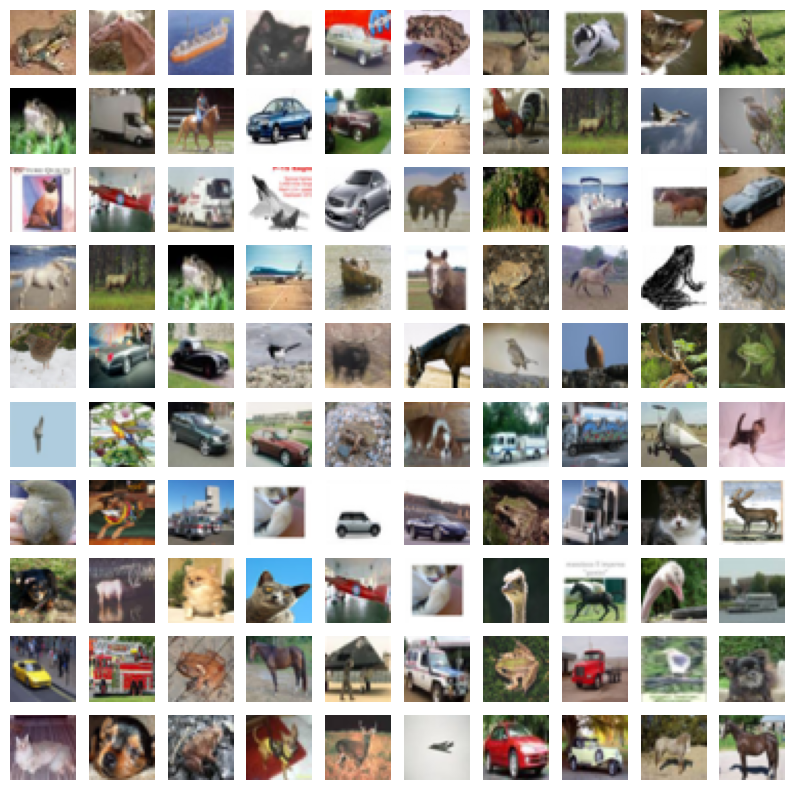

In [10]:
# Plot the top 10 images that activate each feature the most
import numpy as np
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        axes[i, j].imshow(np.transpose(train_dataset[top_images[i, j]][0], (1, 2, 0)))
        axes[i, j].axis('off')

plt.show()

In [12]:
cifar_10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## EXPERIMENTATION

In [37]:
import random
image_number = random.randint(0, len(train_dataset))
image, label = train_dataset[image_number]
image = image.unsqueeze(0).to(device)

encoding = cifar_encoder(image).detach()

# Find the class of the image
# Get the weights of just the first layer of the classifier
classifier = model.classifier
classifier_dense_layer = classifier[0]
classifier_weights = classifier[0].weight  # [10, 64 * 4 * 4]

class_logits = classifier_dense_layer(encoding)
print(class_logits)
class_prediction = torch.log_softmax(class_logits, dim=1).argmax()
print(f"Prediction of the Image: {class_prediction.item()} - {cifar_10_class_names[class_prediction.item()]}")


# Choose another label that is not the class of the image
new_label = random.randint(0, 9)
while new_label == class_prediction:
    new_label = random.randint(0, 9)
print(f"New Label: {new_label} - {cifar_10_class_names[new_label]}")

tensor([[-3.7834, -1.3808,  3.2756,  0.2909,  1.2725,  1.1331,  5.2585,  3.1694,
         -3.3956, -3.7970]], grad_fn=<AddmmBackward0>)
Prediction of the Image: 6 - frog
New Label: 5 - dog


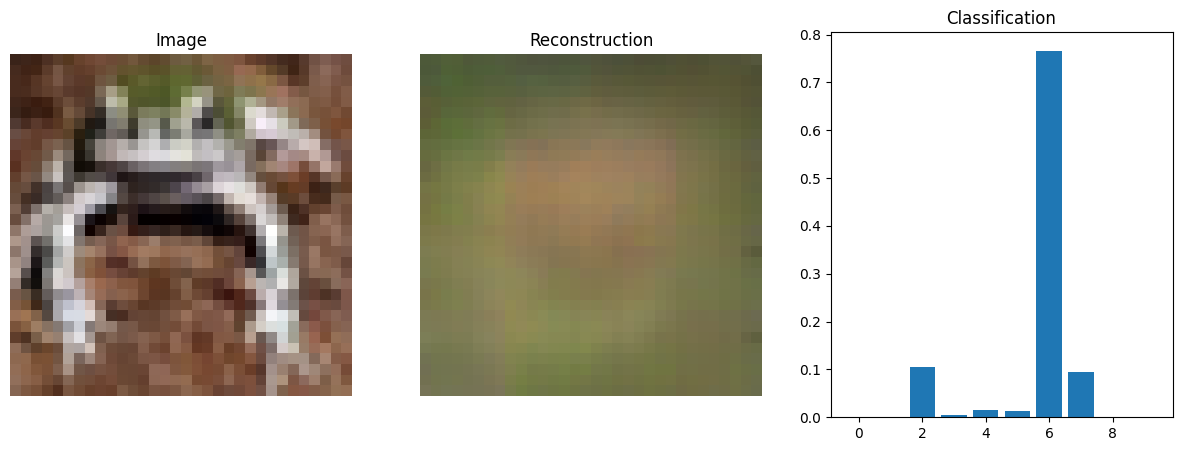

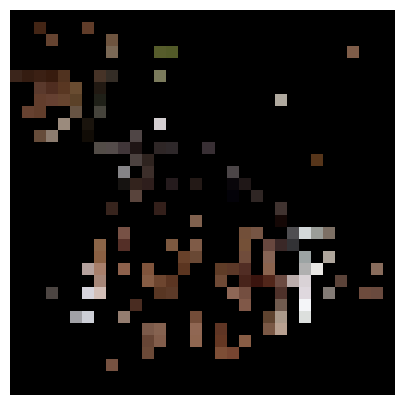

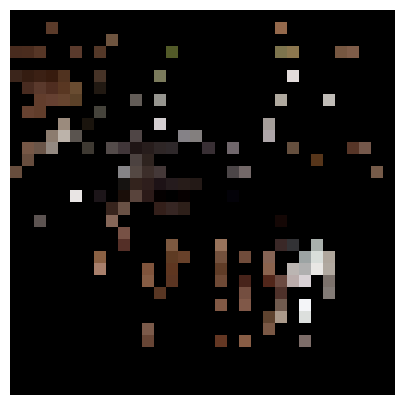

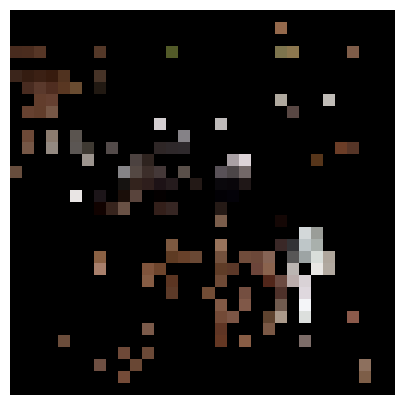

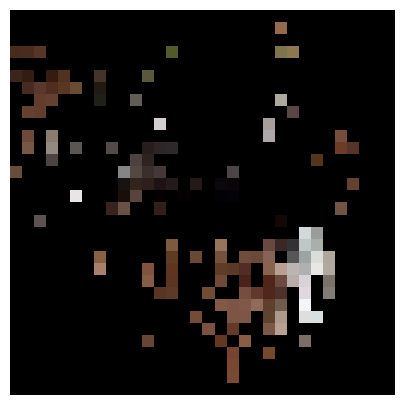

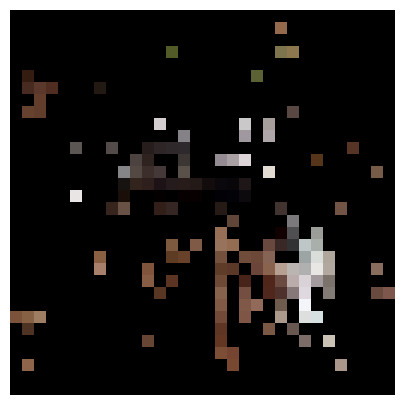

39122


In [38]:
# Now, choose a random image from the test set.
# Pass it through the encoder and get the encoding.
# Pass the encoding through the classifier and get the output.
# Show the image, the reconstruction, and the output of the classifier.
# Now, choose any 5 features out of the 512.
# Compute the activation map of each feature for the image.
# Show the activation map of each feature.

# Choose a random image from the test set
# image_number = torch.randint(0, len(train_dataset), (1,)).item()
image_copy = image.clone()

# Pass the encoding through the classifier and get the output
reconstruction, classification = model(image)


# Show the image, the reconstruction, and the output of the classifier
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(np.transpose(image.detach().squeeze().cpu(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(np.transpose(reconstruction.squeeze().cpu().detach(), (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title('Reconstruction')
axes[2].bar(range(10), torch.softmax(classification, dim=1).squeeze().cpu().detach())
axes[2].set_title('Classification')
plt.show()


# Find the encoding of the image and find the top 5 activations indices as features
features = torch.topk(encoding.squeeze(), 5).indices

for feature in features:
    # Compute the gradient of the encoding with respect to the image
    image.requires_grad = True
    encoding = cifar_encoder(image)
    encoding[:, feature].backward()

    # Find the top 500 pixels that activate the feature the most using the highest absolute gradient values
    activation_map = image.grad.squeeze().abs().sum(0)
    activation_map = activation_map - activation_map.min()
    activation_map = activation_map / activation_map.max()

    # Find the top 500 pixels that activate the feature the most
    top_pixels = activation_map.flatten().topk(150).indices
    top_pixels = torch.stack([top_pixels // 32, top_pixels % 32])


    # Plot the image, now with just the top 500 pixels that activate the feature the most. That is, 500 pixels should be same as the original image and the rest 524 (1024 - 500) pixels should be black.
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    new_image = torch.zeros((3, 32, 32))
    new_image[:, top_pixels[0], top_pixels[1]] = image_copy.squeeze()[:, top_pixels[0], top_pixels[1]]
    axes.imshow(np.transpose(new_image.detach().cpu(), (1, 2, 0)))
    axes.axis('off')
    plt.show()
print(image_number)

In [39]:
cifar_10_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [40]:
import math
def compute_minimal_perturbation(weight_feature_new_class, weight_feature_all_classes, all_label_logits, new_label_logits, new_label):
    min_perturbation_lesser_than = math.inf
    min_perturbation_greater_than = -math.inf

    for i in range(10):
        if i == new_label:
            continue
        weight_feature_other_class = weight_feature_all_classes[i]
        weight_feature_difference = weight_feature_new_class - weight_feature_other_class
        label_logits_difference = all_label_logits[i] - new_label_logits
        if weight_feature_difference > 0:
            min_perturbation_greater_than = max(min_perturbation_greater_than, label_logits_difference / weight_feature_difference)
        else:
            min_perturbation_lesser_than = min(min_perturbation_lesser_than, label_logits_difference / weight_feature_difference)
    
    if min_perturbation_lesser_than >= min_perturbation_greater_than:
        return min_perturbation_lesser_than - 1 if abs(min_perturbation_lesser_than) < abs(min_perturbation_greater_than) else min_perturbation_greater_than + 1, True
    else:
        return None, False


In [41]:
%pip install "cvxpy[CBC,CVXOPT,GLOP,GLPK,GUROBI,MOSEK,PDLP,SCIP,XPRESS]"

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [42]:
import cvxpy as cp

In [43]:
import math
from scipy.optimize import linprog
import cvxpy as cp
def compute_minimal_perturbation(weight_feature_new_class, weight_feature_all_classes, all_label_logits, new_label_logits, new_label):

    perturbation = cp.Variable()
    constraints = []

    for i in range(10):
        if i == new_label:
            continue
        weight_feature_other_class = weight_feature_all_classes[i]
        weight_feature_difference = weight_feature_new_class - weight_feature_other_class
        label_logits_difference = all_label_logits[i] - new_label_logits
        constraint = weight_feature_difference.detach() * perturbation >= label_logits_difference.detach() + 1e-4
        constraints.append(constraint)
    
    objective = cp.Minimize(perturbation ** 2)
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status == cp.OPTIMAL:
        return perturbation.value, True
    else:
        return None, False



In [44]:
classifier = model.classifier

In [45]:
import torch.nn.functional as F

def construct_perturbed_image(model, perturbed_encoding, image, feature_index, new_label):
    perturbed_image = image.clone()
    perturbed_image.requires_grad_(True)
    
    # Perturbation scaling factor
    alpha = 0.1
    max_iterations = 5000
    iteration = 0
    
    # Initial weights for different components of the loss
    mse_weight = 1
    cosine_similarity_weight = 0
    mse_reconstruction_weight = 1
    direct_class_change_loss_weight = 0

    while max_iterations > 0:
        # Zero out previous gradients
        if perturbed_image.grad is not None:
            perturbed_image.grad.zero_()

        # Forward pass to obtain the encoding and required feature value
        obtained_encoding = cifar_encoder(perturbed_image)
        required_encoding = perturbed_encoding
        
        # Extract feature values
        obtained_feature_value = obtained_encoding[0, feature_index]
        required_feature_value = required_encoding[0, feature_index]

        # Compute class logits and required one-hot label
        class_logits_from_perturbed_image = classifier(obtained_encoding.view(1, -1))
        required_one_hot_label_vector = F.one_hot(torch.tensor([new_label]), num_classes=10).float()

        # Loss calculations
        cosine_similarity_loss = F.cosine_embedding_loss(
            class_logits_from_perturbed_image,
            classifier(required_encoding.view(1, -1)),
            torch.tensor([1.0])
        )
        mse_loss = F.mse_loss(obtained_encoding, required_encoding)
        mse_reconstruction_loss = F.mse_loss(perturbed_image, image)
        direct_class_change_loss = F.mse_loss(class_logits_from_perturbed_image, required_one_hot_label_vector)

        # Combined loss
        target_loss = (
            mse_weight * mse_loss +
            cosine_similarity_weight * cosine_similarity_loss +
            mse_reconstruction_weight * mse_reconstruction_loss + 
            direct_class_change_loss_weight * direct_class_change_loss
        )

        # Backpropagate to calculate gradients
        target_loss.backward()
        
        # Manually apply perturbation to the image based on gradients
        with torch.no_grad():
            perturbed_image -= alpha * perturbed_image.grad.sign()

        # Check if the class prediction matches the target
        class_logits = classifier(cifar_encoder(perturbed_image).view(1, -1))
        _, predicted_label = torch.max(class_logits, 1)
        if predicted_label.item() == new_label:
            break

        # Logging
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss = {target_loss.item()}, Feature Value Difference = {required_feature_value.item() - obtained_feature_value.item()}")

        iteration += 1
        max_iterations -= 1

    return perturbed_image, mse_loss.item(), cosine_similarity_loss.item(), mse_reconstruction_loss.item()


In [46]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [47]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
def construct_perturbed_image(model, perturbed_encoding, image, feature_index, new_label):
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad_(True)
    initial_lr = 0.001
    optimizer = optim.Adam([perturbed_image], lr=initial_lr)
    max_iterations = 5000
    iteration = 0

    initial_loss = F.l1_loss(cifar_encoder(perturbed_image), perturbed_encoding)
    mse_weight = 0.01
    cosine_similarity_weight = 0
    mse_reconstruction_weight = 0
    direct_class_change_loss_weight = 0
    experimentation_loss_weight = 0
    structural_similarity_loss_weight = 1

    while max_iterations > 0:
        optimizer.zero_grad()

        obtained_encoding = cifar_encoder(perturbed_image)
        required_encoding = perturbed_encoding

        # Extract feature values
        obtained_feature_value = obtained_encoding[0, feature_index]
        required_feature_value = required_encoding[0, feature_index]

        # Compute class logits and required one-hot label
        class_logits_from_perturbed_image = classifier(obtained_encoding.view(1, -1))
        required_one_hot_label_vector = F.one_hot(torch.tensor([new_label]), num_classes=10).float()

        # Losses
        cosine_similarity_loss = F.cosine_embedding_loss(
            class_logits_from_perturbed_image,
            classifier(required_encoding.view(1, -1)),
            torch.tensor([1.0])
        )
        # mse_loss = F.mse_loss(obtained_encoding, required_encoding)
        mse_loss = F.cosine_embedding_loss(obtained_encoding, required_encoding, torch.tensor([1.0]))
        mse_reconstruction_loss = F.mse_loss(perturbed_image, image)
        direct_class_change_loss = F.mse_loss(class_logits_from_perturbed_image, required_one_hot_label_vector)

        experimentation_loss = (torch.norm(required_encoding - obtained_encoding).item() - abs(required_feature_value.item() - obtained_feature_value.item())) ** 2
        # Adjust win_size and specify channel_axis
        structural_similarity_loss = - ssim(
        perturbed_image.squeeze().detach().cpu().numpy(),
        image.squeeze().detach().cpu().numpy(), 
        data_range=1.0,  # Assuming images are normalized between 0 and 1
        channel_axis=0  # Adjust this if your channel is on a different axis
    )


        # Combined loss
        target_loss = (
            mse_weight * mse_loss +
            cosine_similarity_weight * cosine_similarity_loss +
            mse_reconstruction_weight * mse_reconstruction_loss + 
            direct_class_change_loss_weight * direct_class_change_loss + 
            experimentation_loss_weight * experimentation_loss
        )

        # Backprop and optimize
        target_loss.backward()
        optimizer.step()
        perturbed_image.requires_grad_(True)  # Ensure grad tracking

        # Find the class prediction of perturbed image
        class_logits = classifier(cifar_encoder(perturbed_image).view(1, -1))
        _, predicted_label = torch.max(class_logits, 1)
        if predicted_label.item() == new_label:
            break

        # Logging
        if iteration % 300 == 0:
            print(f"Iteration {iteration}, Loss = {target_loss.item()}, Feature Value Difference = {required_feature_value.item() - obtained_feature_value.item()}")
            print(f"Absolute Feature Vector Difference = {torch.norm(required_encoding - obtained_encoding).item()}")
            # Print each component of the loss (whose weight is not 0)
            for loss_name, loss_value in zip(
                ['MSE Loss', 'Cosine Similarity Loss', 'MSE Reconstruction Loss', 'Direct Class Change Loss', 'Experimentation Loss', 'Structural Similarity Loss'],
                [mse_loss, cosine_similarity_loss, mse_reconstruction_loss, direct_class_change_loss, experimentation_loss, structural_similarity_loss]
            ):
                print(f"{loss_name} = {loss_value}")
            print(f"Required Encoding = {required_encoding}")
            print(f"Obtained Encoding = {obtained_encoding}")
    
        iteration += 1
        max_iterations -= 1

    # print(f"Target Loss = {target_loss.item()}")
    # print(f"Perturved Image Shape = {perturbed_image.shape}")
    return perturbed_image, mse_loss.item(), cosine_similarity_loss.item(), mse_reconstruction_loss.item()

Label to be changed from frog to dog
It is not possible to perturb feature number 0 to change the prediction from frog to dog
Minimal Perturbation Required in Feature Number 1 to change the prediction from frog to dog: 117.55207466879986
It is not possible to perturb feature number 2 to change the prediction from frog to dog
It is not possible to perturb feature number 3 to change the prediction from frog to dog
It is not possible to perturb feature number 4 to change the prediction from frog to dog
It is not possible to perturb feature number 5 to change the prediction from frog to dog
It is not possible to perturb feature number 6 to change the prediction from frog to dog
It is not possible to perturb feature number 7 to change the prediction from frog to dog
It is not possible to perturb feature number 8 to change the prediction from frog to dog
It is not possible to perturb feature number 9 to change the prediction from frog to dog
It is not possible to perturb feature number 10 to

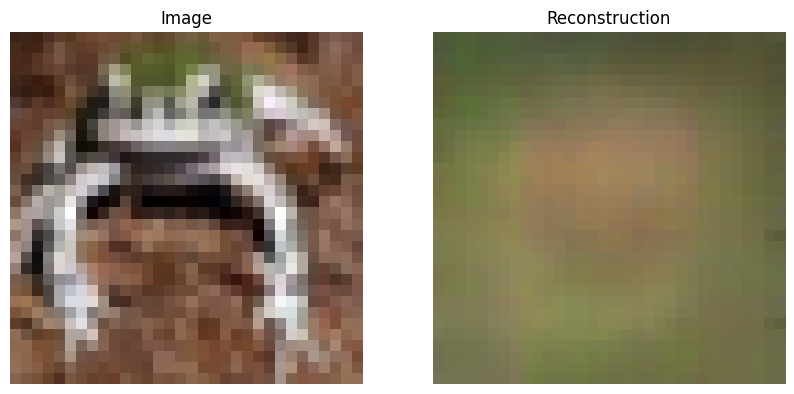

================= FEATURE 1 =================
================= COMPUTING PERTURBED IMAGE FOR FEATURE 1 =================
Iteration 0, Loss = 0.008328456431627274, Feature Value Difference = 117.55207180976868
Absolute Feature Vector Difference = 117.55207061767578
MSE Loss = 0.8328456282615662
Cosine Similarity Loss = 0.05354100465774536
MSE Reconstruction Loss = 0.0
Direct Class Change Loss = 38.599822998046875
Experimentation Loss = 1.4210854715202004e-12
Structural Similarity Loss = -1.0
Required Encoding = tensor([[-4.1450e-01,  1.1811e+02, -1.7513e-01,  5.2720e-01,  5.7105e-02,
          3.5022e-01, -8.2530e-01, -7.2017e-01,  6.8026e-01, -6.3743e-01,
          6.4456e-01, -8.5997e+00, -3.7347e+00,  7.3244e+00,  1.8118e-01,
          1.2186e+00,  3.9612e+00,  4.4297e+00, -5.7185e-01, -3.4313e-01,
          6.9133e+00, -4.0522e-01, -5.7592e-01,  1.4836e-01, -5.3004e-01,
          5.8948e-01, -4.6616e-01,  2.5897e+00,  5.3176e-02,  2.9232e+00,
          2.2869e-01,  1.9917e-01]])
Ob

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================= RESULTS FOR FEATURE 11 AFTER PERTURBING=================
Original Class Logits: tensor([-3.7834, -1.3808,  3.2756,  0.2909,  1.2725,  1.1331,  5.2585,  3.1694,
        -3.3956, -3.7970], grad_fn=<SelectBackward0>), New Class Logits: tensor([-7.1005, -5.8333, -2.5233, -4.0747, -1.5465, -1.2642, -2.1060, -1.2686,
        -7.5995, -8.7789], grad_fn=<SelectBackward0>)
Actual Class: 6, Predicted Class From New Image: 5, Predicted Class from Encoding: 5
Initial Encoding of Feature 11 = -8.599676111067438
Required Encoding of Feature 11 = 0.9038263559341431
Learned Encoding of Feature 11 = 0.9828776121139526
================= FEATURE 16 =================
================= COMPUTING PERTURBED IMAGE FOR FEATURE 16 =================
Iteration 0, Loss = 0.006109278183430433, Feature Value Difference = 100.35542798042297
Absolute Feature Vector Difference = 100.35543060302734
MSE Loss = 0.6109278202056885
Cosine Similarity Loss = 0.10333633422851562
MSE Reconstruction Loss = 0.0


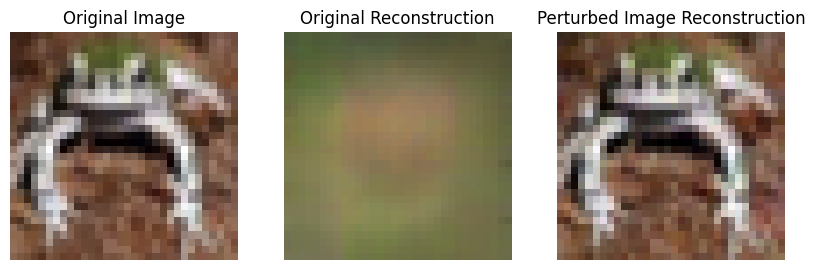

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================= PLOTTING IMAGE 1 =================
Original Class Logits: tensor([-3.7834, -1.3808,  3.2756,  0.2909,  1.2725,  1.1331,  5.2585,  3.1694,
        -3.3956, -3.7970], grad_fn=<SelectBackward0>)
Class Logit of the Perturbed Image for the Original Class (from new encoding)- frog: -2.0636796951293945
Class Logit of the Perturbed Image for the Other Class (from new encoding)- dog: -1.2959802150726318
Class Logit of the Perturbed Image for the Predicted Class (from new encoding)- dog: -1.2959802150726318
Prediction of the Perturbed Encoding: tensor([[-6.8325, -5.6305, -2.4917, -3.9309, -1.5241, -1.2960, -2.0637, -1.2961,
         -7.2877, -8.4040]], grad_fn=<LogSoftmaxBackward0>)
Class Logit of the Perturbed Image for the Original Class (from new image)- frog: -2.1059911251068115
Class Logit of the Perturbed Image for the new Class (from new image)- dog: -1.2642219066619873
Class Logit of the Perturbed Image for the Predicted Class (from new image)- dog: -1.2642219066619873


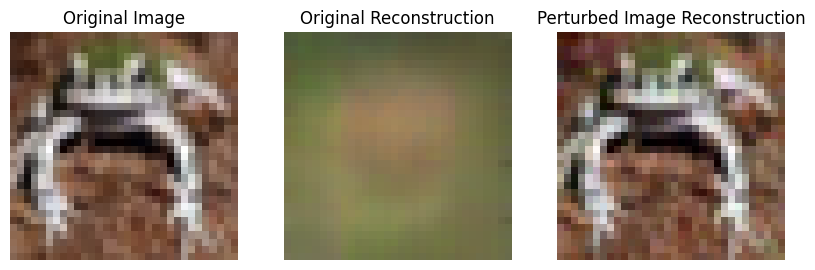

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


================= PLOTTING IMAGE 2 =================
Original Class Logits: tensor([-3.7834, -1.3808,  3.2756,  0.2909,  1.2725,  1.1331,  5.2585,  3.1694,
        -3.3956, -3.7970], grad_fn=<SelectBackward0>)
Class Logit of the Perturbed Image for the Original Class (from new encoding)- frog: -0.6965761780738831
Class Logit of the Perturbed Image for the Other Class (from new encoding)- dog: -0.6964731812477112
Class Logit of the Perturbed Image for the Predicted Class (from new encoding)- dog: -0.6964731812477112
Prediction of the Perturbed Encoding: tensor([[-47.1725, -52.1652, -13.9748,  -5.7670,  -8.3274,  -0.6965,  -0.6966,
         -15.9098, -22.6311, -52.1478]], grad_fn=<LogSoftmaxBackward0>)
Class Logit of the Perturbed Image for the Original Class (from new image)- frog: -1.1257723569869995
Class Logit of the Perturbed Image for the new Class (from new image)- dog: -1.0161985158920288
Class Logit of the Perturbed Image for the Predicted Class (from new image)- dog: -1.0161985

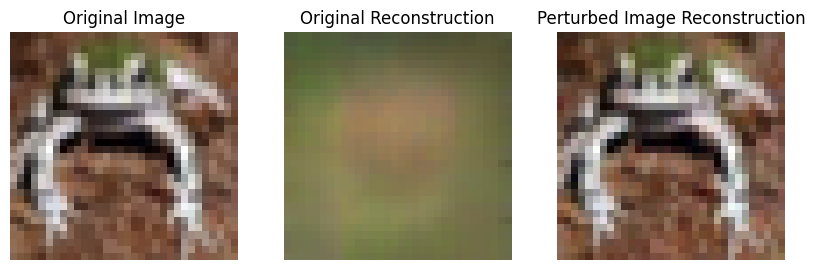

In [48]:
print(f"Label to be changed from {cifar_10_class_names[class_prediction]} to {cifar_10_class_names[new_label]}")


# Find difference between class logits of all the labels except the new label
all_label_logits = class_logits[0]
new_label_logits = all_label_logits[new_label]
minimal_perturbations = []
no_perturbation_features = []
top_20_minimum_perturbations = {}

for feature in range (len(encoding[0])):
    # Find the classifier weights for the feature for the class of the image and the other label
    # weight_feature_actual_classes is the classifier weights of the feature of all classes other than "other class"
    weight_feature_all_classes = classifier_weights[:, feature]
    weight_feature_new_class = classifier_weights[new_label, feature]

    minimal_perturbation = compute_minimal_perturbation(weight_feature_new_class, weight_feature_all_classes, all_label_logits, new_label_logits, new_label)
    if not minimal_perturbation[1] or encoding.detach()[0, feature] + minimal_perturbation[0] < 0:
        print(f"It is not possible to perturb feature number {feature} to change the prediction from {cifar_10_class_names[class_prediction]} to {cifar_10_class_names[new_label]}")
        no_perturbation_features.append(feature)
        continue
    # Compute the difference between the weights
    minimal_perturbations.append(minimal_perturbation[0])
    if len(top_20_minimum_perturbations) < 20:
        top_20_minimum_perturbations[feature] = minimal_perturbation[0]
    else:
        max_key = max(top_20_minimum_perturbations, key=top_20_minimum_perturbations.get)
        if minimal_perturbation[0] < top_20_minimum_perturbations[max_key]:
            del top_20_minimum_perturbations[max_key]
            top_20_minimum_perturbations[feature] = minimal_perturbation[0]
    print(f"Minimal Perturbation Required in Feature Number {feature} to change the prediction from {cifar_10_class_names[class_prediction]} to {cifar_10_class_names[new_label]}: {minimal_perturbation[0]}")
print("--------------------------------------------------------------------")

reconstruction = model.decoder(encoding)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(np.transpose(image.detach().squeeze().cpu(), (1, 2, 0)))
axes[0].axis('off')
axes[0].set_title('Image')
axes[1].imshow(np.transpose(reconstruction.squeeze().cpu().detach(), (1, 2, 0)))
axes[1].axis('off')
axes[1].set_title('Reconstruction')
plt.show()

no_perturb= 0
images_to_plot = []
for feature in top_20_minimum_perturbations:
    print("================= FEATURE {} =================".format(feature))
    if feature in no_perturbation_features:
        no_perturb += 1
        continue
    encoding_copy = encoding.clone().detach()
    # Perturb the encoding of the image by the minimal perturbation
    # encoding[feature] += minimal_perturbations[index]
    encoding_copy[0, feature] += top_20_minimum_perturbations[feature]

    # Run the perturbed encoding through the classifier and get the logits of the actual class and the other class
    class_logits_from_new_encoding = classifier(encoding_copy)
    
    # Reconstruct the image based on the perturbed encoding_copy
    print(f"================= COMPUTING PERTURBED IMAGE FOR FEATURE {feature} =================")
    perturbed_image, mse_loss, cosine_sim_loss, mse_recon_loss = construct_perturbed_image(model, encoding_copy, image, feature, new_label)

    # Run the perturbed image through the classifier and plot the output    
    _, class_logits_new = model(perturbed_image[0].unsqueeze(0))
    class_prediction_from_new_image = torch.softmax(class_logits_new, dim=1).argmax()
    class_prediction_from_new_encoding = torch.softmax(class_logits_from_new_encoding, dim=1).argmax()
    print(f"================= RESULTS FOR FEATURE {feature} AFTER PERTURBING=================")
    print(f"Original Class Logits: {class_logits[0]}, New Class Logits: {class_logits_new[0]}\nActual Class: {label}, Predicted Class From New Image: {class_prediction_from_new_image.item()}, Predicted Class from Encoding: {class_prediction_from_new_encoding.item()}")
    print(f"Initial Encoding of Feature {feature} = {encoding_copy[0, feature] - top_20_minimum_perturbations[feature]}")
    print(f"Required Encoding of Feature {feature} = {encoding_copy[0, feature]}")
    print(f"Learned Encoding of Feature {feature} = {cifar_encoder(perturbed_image).detach()[0, feature]}")
    if class_prediction_from_new_image == new_label:
        if len(images_to_plot) < 5:
            images_to_plot.append((perturbed_image, class_logits_new, class_logits_from_new_encoding, class_prediction_from_new_encoding, class_prediction_from_new_image, mse_loss, cosine_sim_loss, mse_recon_loss))
        else:
            if mse_loss + mse_recon_loss < max([x[4] + x[6] for x in images_to_plot]):
                replace_index = np.argmax([x[4] + x[6] for x in images_to_plot])
                images_to_plot[replace_index] = (perturbed_image, class_logits_new, class_logits_from_new_encoding, class_prediction_from_new_encoding, class_prediction_from_new_image, mse_loss, cosine_sim_loss, mse_recon_loss)
    print("=====================================================================================================")

print(f"================= PLOTTING IMAGES =================")
for index, image_set in enumerate(images_to_plot):
    perturbed_image, class_logits_new, class_logits_from_new_encoding, class_prediction_from_new_encoding, class_prediction_from_new_image, mse_loss, cosine_sim_loss, mse_recon_loss = image_set
    print(f"================= PLOTTING IMAGE {index} =================")
    print(f"Original Class Logits: {class_logits[0]}")
    print(f"Class Logit of the Perturbed Image for the Original Class (from new encoding)- {cifar_10_class_names[class_prediction]}: {class_logits_from_new_encoding[0, class_prediction]}")
    print(f"Class Logit of the Perturbed Image for the Other Class (from new encoding)- {cifar_10_class_names[new_label]}: {class_logits_from_new_encoding[0, new_label]}")
    print(f"Class Logit of the Perturbed Image for the Predicted Class (from new encoding)- {cifar_10_class_names[class_prediction_from_new_encoding.item()]}: {class_logits_from_new_encoding[0, class_prediction_from_new_encoding]}")
    print(f"Prediction of the Perturbed Encoding: {(class_logits_from_new_encoding)}")

    print(f"Class Logit of the Perturbed Image for the Original Class (from new image)- {cifar_10_class_names[class_prediction]}: {class_logits_new[0, class_prediction]}")
    print(f"Class Logit of the Perturbed Image for the new Class (from new image)- {cifar_10_class_names[new_label]}: {class_logits_new[0, new_label]}")
    print(f"Class Logit of the Perturbed Image for the Predicted Class (from new image)- {cifar_10_class_names[class_prediction_from_new_image.item()]}: {class_logits_new[0, class_prediction_from_new_image]}")
    print(f"Prediction of the Reconstructed Perturbed Image: {class_logits_new}")
    # Plot the original image and the perturbed image side by side
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    axes[0].imshow(np.transpose(image.squeeze().cpu().detach(), (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    axes[1].imshow(np.transpose(reconstruction.squeeze().cpu().detach(), (1, 2, 0)))
    axes[1].axis('off')
    axes[1].set_title('Original Reconstruction')
    axes[2].imshow(np.transpose(perturbed_image[0].cpu().detach(), (1, 2, 0)))
    axes[2].axis('off')
    axes[2].set_title('Perturbed Image Reconstruction')
    plt.show()
    print("=====================================================================================================")